## 0. import

In [37]:
%matplotlib inline
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

## 0-1. os path

In [38]:
import os
print(os.getcwd())

D:\jupyter_notebook\captcha_breaker-review


## 0-2. img_show

In [39]:
def img_show(img):
    fig = plt.figure() # 建立一個Figure（空的顯示區） 
#     print("shape = ",img.shape)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## 1-0. RGB 原圖

In [40]:
datasets = glob.glob("./datasets/captcha_original/*.png")

data_num = 100

i = 0
for idx, data in enumerate(datasets):
    img = cv2.imread(datasets[idx]) #讀進來BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR編碼轉 RGB 

#     img_show(img)

    i = i + 1
    if(i > data_num):
        break

## 1-1. 轉灰階讀入

In [41]:
data_num = 100
img_list = []

i = 0
for idx, data in enumerate(datasets):
    img = cv2.imread(datasets[idx], 0) #讀進來灰階
    img_list.append(img)

#     img_show(img)

    i = i + 1
    if(i > data_num):
        break

## 2. threshold 圖片二值化

In [42]:
thresh_list = []
for img in img_list:
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    thresh_list.append(thresh)
#     img_show(thresh)

## 3. findContours 找邊框

In [43]:
contour_list = []
cnt = 0

for thresh in thresh_list:
    # findContours
    contour_img, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for ele in contours:        
        [x,y,w,h] = cv2.boundingRect(ele) #多邊形轉方形
        if  h > 20 and h < 100: # 文字至少要有超過"20"的高度 (不夠高 = 誤判), 小於"100" (全圖當一張圖了)      
#             print("[x,y,w,h] =",[x,y,w,h])

            # 各邊緣加大 10 pixels
            # 方框劃上去
            cv2.rectangle(contour_img, (x - 10, y - 10), (x + w + 10, y + h + 10), (0, 0, 0), 2)
            # 截圖(方框)
            roi = contour_img[y - 10 : y + h + 10, x - 10 : x + w + 10]
#             img_show(roi)
#             print(roi.shape)
            if roi.shape[0] > 20 and roi.shape[1] > 20:
                contour_list.append(roi) # 保存結果 
                cnt = cnt + 1

print("已存入 {} 張圖".format(cnt))

已存入 619 張圖


## 4-0. model testing (CNN data)

In [44]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [45]:
x_train_4d = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test_4d = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
print(x_train_4d.shape)
print(x_test_4d.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [46]:
x_train_normalize = x_train_4d / 255
x_test_normalize = x_test_4d / 255
print(x_train_normalize.shape)
print(x_test_normalize.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [47]:
def plot_images_labels_prediction(images, labels, prediction, idx, num):
    fig = plt.gcf()
    fig.set_size_inches(15, 20)
    for i in range(0, num):
        ax = plt.subplot(10, 10, 1 + i)
        ax.imshow(images[idx])
        title = 'Label: ' + str(labels[idx])
        if len(prediction) > 0:
            title = title + '\n' + 'Predict: ' + str(prediction[idx])
        if str(labels[idx]) == str(prediction[idx]):
            ax.set_title(title, fontsize = 10) # same
        else:
            ax.set_title(title, fontsize = 15)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()

In [48]:
prediction = model.predict_classes(x_test_normalize)

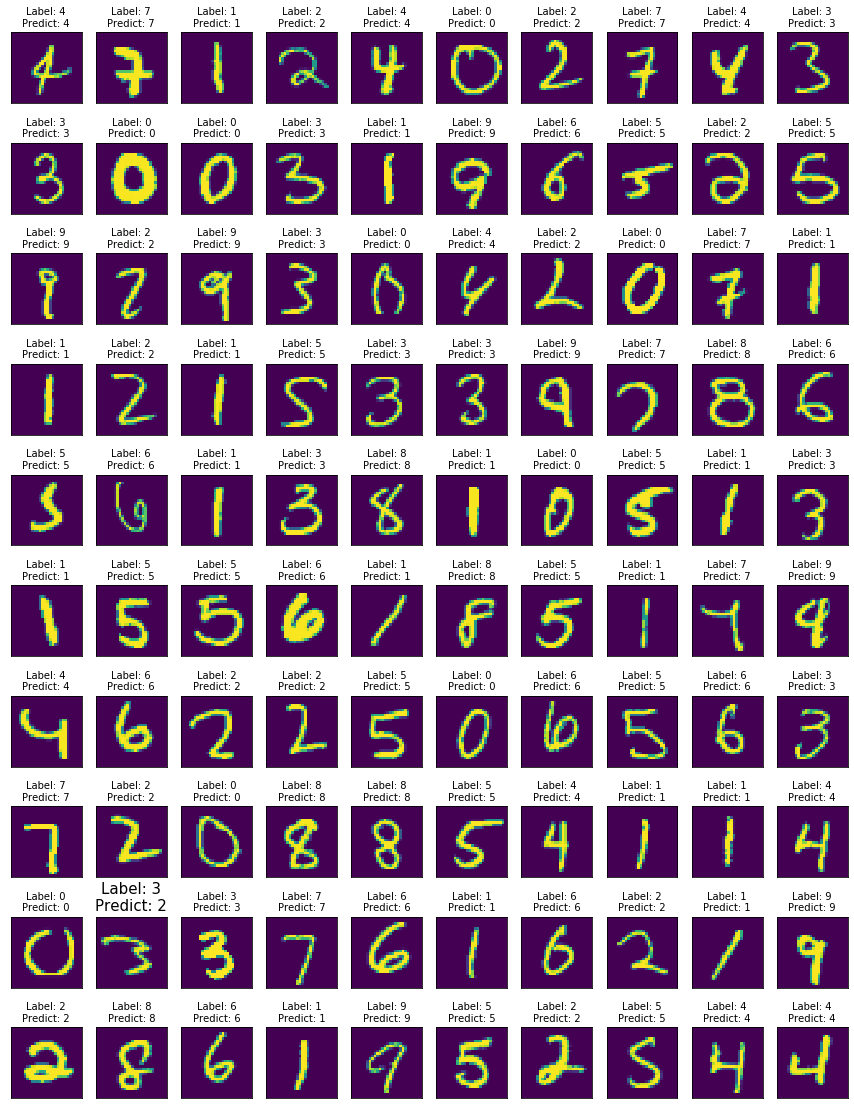

In [49]:
plot_images_labels_prediction(x_test, y_test, prediction, 300, 100)

## 4-1. model testing (real captcha, our data)

In [50]:
from keras.models import load_model

model = load_model('./3_model_training_and_testing/model-save/mnist.h5')

In [51]:
def img_resize(img):
    return cv2.resize(img, (28, 28))

In [52]:
def img_normalize(img):
    return img / 255

In [53]:
def test_model(img):
#     img_show(img)
    
    digit = img.reshape(1, 28, 28, 1).astype('float32')
    pred = model.predict_classes(digit)
    
#     print("prediction: ", pred)
    return str(pred[0])

In [54]:
img_norm_list = []
prediction_list = []
for roi in contour_list:
#     print(roi.shape)
    img_norm = img_normalize(img_resize(roi))
    img_norm_list.append(img_norm)
    pred = test_model(img_norm)
    prediction_list.append(pred)

In [55]:
def plot_images_prediction(images, prediction, num):
    fig = plt.gcf()
    fig.set_size_inches(15, 20)
    for idx in range(num):
        ax = plt.subplot(10, 10, 1 + idx)
        ax.imshow(images[idx])
        title = 'Predict: ' + str(prediction[idx])
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()

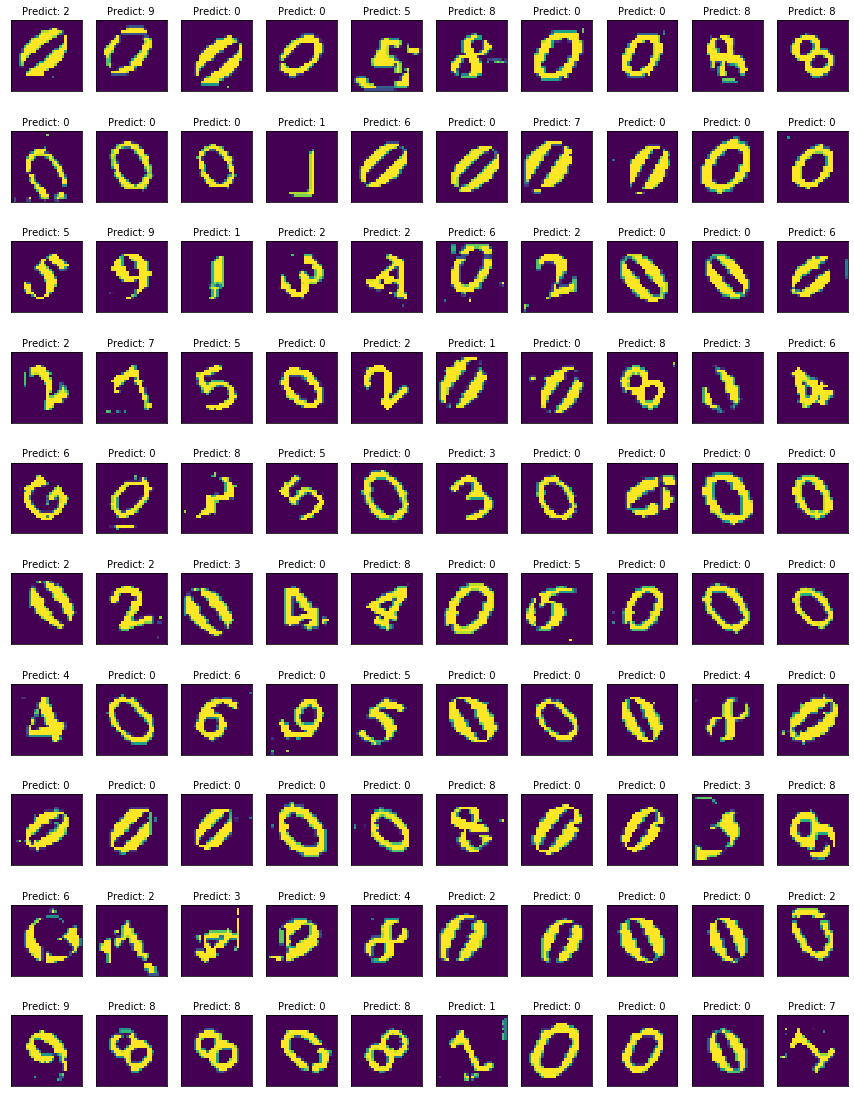

In [56]:
plot_images_prediction(img_norm_list, prediction_list, 100)